# Data Preprocessing:
Data preprocessing is a predominant step in machine learning to yield highly accurate and insightful results. Greater the quality of data, greater is the reliance on the produced results. **Incomplete, noisy, and inconsistent data** are the properties of large real-world datasets. Data preprocessing helps in increasing the quality of data by filling in missing incomplete data, smoothing noise and resolving inconsistencies.

* **Incomplete data** can occur for a number of reasons. Attributes of interest may not always be available, such as customer information for sales transaction data. Relevant data may not be recorded due to a misunderstanding, or because of equipment malfunctions.
* There are many possible reasons for **noisy data** (having incorrect attribute values). The data collection instruments used may be faulty. There may have been human or computer errors occurring at data entry. Errors in data transmission can also occur. Incorrect data may also result from inconsistencies in naming conventions or data codes used, or inconsistent formats for input fields, such as date.

There are a number of data preprocessing techniques available such as,
1. **Data Cleaning**
2. **Data Integration**
3. **Data Transformation**
4. **Data Reduction**

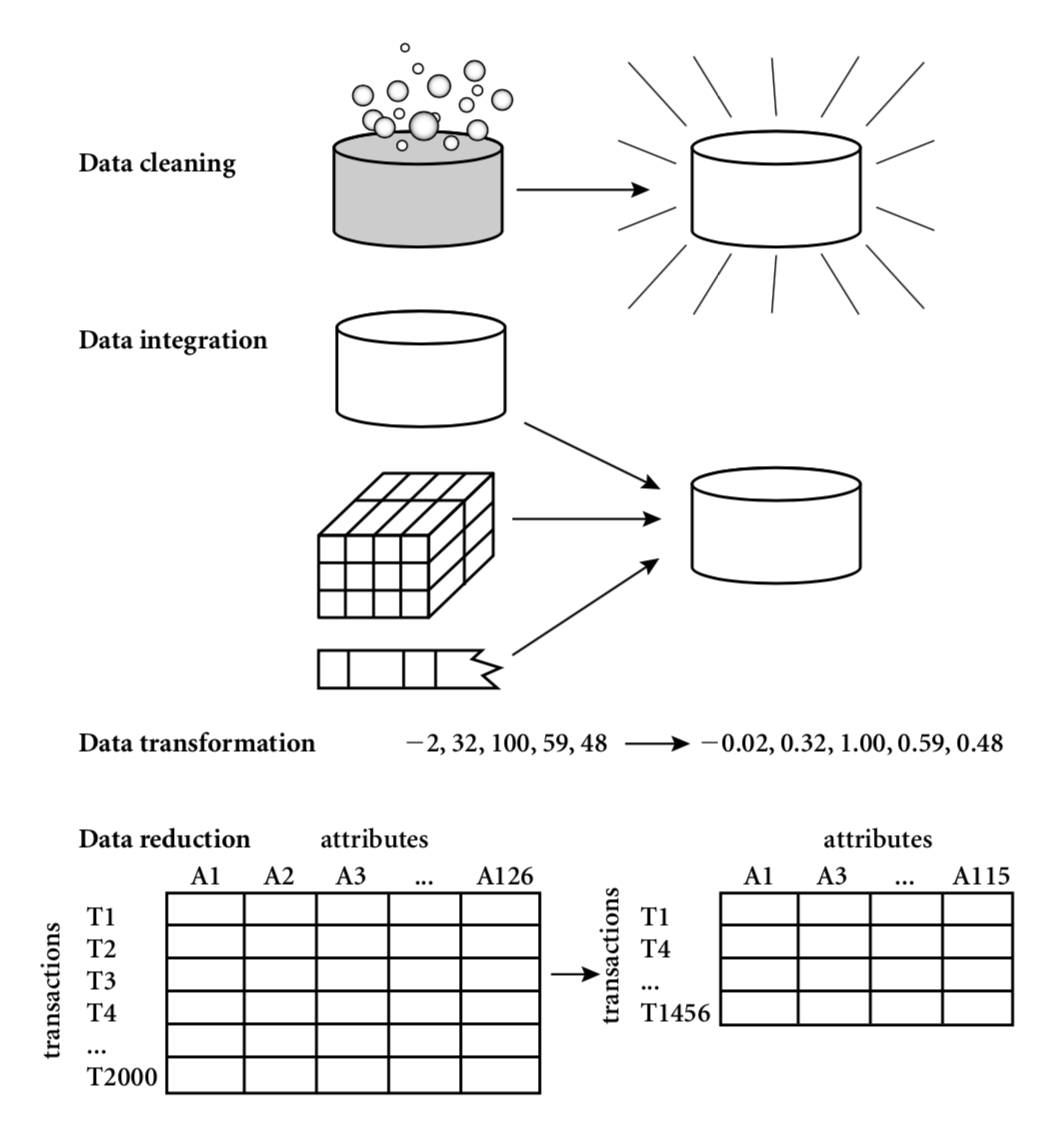

* **Data cleaning** can be applied to filling in missing values, remove noise, resolving inconsistencies, identifying and removing outliers in the data. 
* **Data integration** merges data from multiple sources into a coherent data store, such as a data warehouse. 
* **Data transformations**, such as normalization, may be applied. For example, normalization may improve the accuracy and efficiency of mining algorithms involving distance measurements. 
* **Data reduction** can reduce the data size by eliminating redundant features, or clustering, for instance. 

**Reference**: Data Mining:Concepts and Techniques Second Edition, Jiawei Han, Micheline Kamber.

**PS:** This is my first kaggle notebook contribution. Hope you like it!!

# Import the required libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import (GradientBoostingRegressor, GradientBoostingClassifier)
import xgboost

### Load the dataset for training and testing

In [ ]:
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# 1. Data Cleaning
### 1.1 Find the missing percentage of each columns in training set.


In [ ]:
def find_missing_percent(data):
    """
    Returns dataframe containing the total missing values and percentage of total
    missing values of a column.
    """
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissingVals':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isnull().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])),ignore_index=True)
    return miss_df

In [ ]:
miss_df = find_missing_percent(train)
'''Displays columns with missing values'''
display(miss_df[miss_df['PercentMissing']>0.0])
print("\n")
print(f"Number of columns with missing values:{str(miss_df[miss_df['PercentMissing']>0.0].shape[0])}")

### 1.2 Drop the columns which have more than 70% of missing values

In [ ]:
drop_cols = miss_df[miss_df['PercentMissing'] >70.0].ColumnName.tolist()
print(f"Number of columns with more than 70%: {len(drop_cols)}")
train = train.drop(drop_cols,axis=1)
test = test.drop(drop_cols,axis =1)

miss_df = miss_df[miss_df['ColumnName'].isin(train.columns)]
'''Columns to Impute'''
impute_cols = miss_df[miss_df['TotalMissingVals']>0.0].ColumnName.tolist()
miss_df[miss_df['TotalMissingVals']>0.0]

In [ ]:
'''Segregate the numeric and categoric data'''
numeric_cols = train.select_dtypes(['float','int']).columns
categoric_cols = train.select_dtypes('object').columns

train_numeric = train[numeric_cols[:-1]]
train_categoric = train[categoric_cols]

test_numeric = test[numeric_cols[:-1]]
test_categoric = test[categoric_cols]

nominal_cols = ['MSZoning', 'Street','LandContour','Neighborhood','Condition1','Condition2',
                'RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',
                'Heating','GarageType','SaleType','SaleCondition']
ordinal_cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                'BsmtFinType2','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
                'FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','LotShape',
                'Utilities','LandSlope','BldgType','HouseStyle','LotConfig']

### 1.3 MICE (Multiple Imputation by Chained Equation)
Imputation of missing values can be done using two techniques,
* **Single Imputation**
    * Single imputation denotes that the missing value is replaced by a value only once.
* **Multiple Imputation**
    * In multiple imputation, the imputation process is repeated multiple times resulting in multiple imputed datasets.
    
#### MICE Algorithm:
The chained equation process can be broken down into four general steps:

* **Step 1:** A simple imputation, such as imputing the mean, is performed for every missing value in the dataset. These mean imputations can be thought of as “place holders.”
* **Step 2:** The “place holder” mean imputations for one variable (“var”) are set back to missing.
* **Step 3:** The observed values from the variable “var” in Step 2 are regressed(can use any other regressors like Gradient Boosting Regressor or XGBoost Regressor for numeric data) on the other variables in the imputation model, which may or may not consist of all of the variables in the dataset. In other words, “var” is the dependent variable in a regression model and all the other variables are independent variables in the regression model. These regression models operate under the same assumptions that one would make when performing linear, logistic, or Poison regression models outside of the context of imputing missing data.
* **Step 4:** The missing values for “var” are then replaced with predictions (imputations) from the regression model. When “var” is subsequently used as an independent variable in the regression models for other variables, both the observed and these imputed values will be used.
* **Step 5:** Steps 2–4 are then repeated for each variable that has missing data. The cycling through each of the variables constitutes one iteration or “cycle.” At the end of one cycle all of the missing values have been replaced with predictions from regressions that reflect the relationships observed in the data.
* **Step 6:** Steps 2–4 are repeated for a number of cycles, with the imputations being updated at each cycle.

**Reference:** https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

#### MICE Algorithm for Categorical data:
Before going through the steps 1 to 6 in MICE algorithm the following steps must be done in order to impute categorical data.
* **Step 1:** Ordinal Encode the non-null values
* **Step 2:** Use MICE imputation with Gradient Boosting Classifier to impute the ordinal encoded data
* **Step 3:** Convert back from ordinal values to categorical values.
* **Step 4:** Follow steps 1 to 6 in MICE Algorithm. Instead of using Mean imputation for initial strategy use **Mode imputation**.

**Reference:** https://projector-video-pdf-converter.datacamp.com/17404/chapter4.pdf



In [ ]:
def mice_imputation_numeric(train_numeric, test_numeric):
    """
    Impute numeric data using MICE imputation with Gradient Boosting Regressor.
    """
    iter_imp_numeric = IterativeImputer(GradientBoostingRegressor())
    imputed_train = iter_imp_numeric.fit_transform(train_numeric)
    imputed_test = iter_imp_numeric.transform(test_numeric)
    train_numeric_imp = pd.DataFrame(imputed_train, columns = train_numeric.columns, index= train_numeric.index)
    test_numeric_imp = pd.DataFrame(imputed_test, columns = test_numeric.columns, index = test_numeric.index)
    return train_numeric_imp, test_numeric_imp

def mice_imputation_categoric(train_categoric, test_categoric):
    """
    Impute categoric data using MICE imputation with Gradient Boosting Classifier.
    Steps:
    1. Ordinal Encode the non-null values
    2. Use MICE imputation with Gradient Boosting Classifier to impute the ordinal encoded data
    3. Inverse transform the ordinal encoded data.
    """
    ordinal_dict={}
    for col in train_categoric:
        '''Ordinal encode train data'''
        ordinal_dict[col] = OrdinalEncoder()
        nn_vals = np.array(train_categoric[col][train_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].fit_transform(nn_vals)).reshape(-1,)
        train_categoric[col].loc[train_categoric[col].notnull()] = nn_vals_arr

    for col in test_categoric:
        '''Ordinal encode test data'''
        nn_vals = np.array(test_categoric[col][test_categoric[col].notnull()]).reshape(-1,1)
        nn_vals_arr = np.array(ordinal_dict[col].transform(nn_vals)).reshape(-1,)
        test_categoric[col].loc[test_categoric[col].notnull()] = nn_vals_arr
    
    '''Impute the data using MICE with Gradient Boosting Classifier'''
    iter_imp_categoric = IterativeImputer(GradientBoostingClassifier(), max_iter =5, initial_strategy='most_frequent')
    imputed_train = iter_imp_categoric.fit_transform(train_categoric)
    imputed_test = iter_imp_categoric.transform(test_categoric)
    train_categoric_imp = pd.DataFrame(imputed_train, columns =train_categoric.columns,index = train_categoric.index).astype(int)
    test_categoric_imp = pd.DataFrame(imputed_test, columns=test_categoric.columns,index =test_categoric.index).astype(int)
    
    '''Inverse Transform'''
    for col in train_categoric_imp.columns:
        oe = ordinal_dict[col]
        train_arr= np.array(train_categoric_imp[col]).reshape(-1,1)
        test_arr = np.array(test_categoric_imp[col]).reshape(-1,1)
        train_categoric_imp[col] = oe.inverse_transform(train_arr)
        test_categoric_imp[col] = oe.inverse_transform(test_arr)

    return train_categoric_imp, test_categoric_imp


In [ ]:
train_numeric_imp, test_numeric_imp = mice_imputation_numeric(train_numeric,test_numeric)
train_categoric_imp, test_categoric_imp = mice_imputation_categoric(train_categoric, test_categoric)

'''Concatenate Numeric and Categoric Training and Test set data '''
train = pd.concat([train_numeric_imp, train_categoric_imp, train['SalePrice']], axis = 1)
test = pd.concat([test_numeric_imp, test_categoric_imp], axis =1)

# 2. Data Visualization

In [ ]:
def plot_histogram(train, col1, col2, cols_list, last_one =False):
    """
    Plot the histogram for the numerical columns. The bin width
    is calculated by Freedman Diaconis Rule and Sturges rule.
    
    Freedman-Diaconis Rule:
    Freedman-Diaconis Rule is a rule to find the optimal number of bins.
    Bin width: (2 * IQR)/(N^1/3)
    N - Size of the data
    Number of bins : (Range/ bin-width)
    
    Disadvantage: The IQR might be zero for certain columns. In
    that case the bin width might be equal to infinity. In that case 
    the actual range of the data is returned as bin width.
    
    Sturges Rule:
    Sturges Rule is a rule to find the optimal number of bins.
    Bin width: (Range/ bin-width)
    N - Size of the data
    Number of bins : ceil(log2(N))+1
    
    """
    if(col1 in cols_list):
        freq1, bin_edges1 = np.histogram(train[col1],bins='sturges')
    else:
        freq1, bin_edges1 = np.histogram(train[col1],bins='fd')
    if(col2 in cols_list):
        freq2, bin_edges2 = np.histogram(train[col2],bins='sturges')
    else:
        freq2, bin_edges2 = np.histogram(train[col2],bins='fd')
        
    if(last_one!=True):
        plt.figure(figsize=(45,18))  
        ax1 = plt.subplot(1,2,1)
        ax1.set_title(col1,fontsize=45)
        ax1.set_xlabel(col1,fontsize=40)
        ax1.set_ylabel('Frequency',fontsize=40)
        train[col1].hist(bins=bin_edges1,ax = ax1, xlabelsize=30, ylabelsize=30)
        
    else:
        plt.figure(figsize=(20,10))
        ax1 = plt.subplot(1,2,1)
        ax1.set_title(col1,fontsize=25)
        ax1.set_xlabel(col1,fontsize=20)
        ax1.set_ylabel('Frequency',fontsize=20)
        train[col1].hist(bins=bin_edges1,ax = ax1, xlabelsize=15, ylabelsize=15)
    
    if(last_one != True):
        ax2 = plt.subplot(1,2,2)
        ax2.set_title(col2,fontsize=45)
        ax2.set_xlabel(col2,fontsize=40)
        ax2.set_ylabel('Frequency',fontsize=40)
        train[col2].hist(bins=bin_edges2, ax = ax2, xlabelsize=30, ylabelsize=30)


In [ ]:
'''
These columns have IQR equal to zero. Freedman Diaconis Rule doesn't work significantly well for these columns. 
Use sturges rule to find the optimal number of bins for the columns.
'''
cols_list = ['LowQualFinSF','BsmtFinSF2','BsmtHalfBath','KitchenAbvGr',
             'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal']

# Except ID
hist_cols = numeric_cols[1:]
for i in range(0,len(hist_cols),2):
    if(i == len(hist_cols)-1):
        plot_histogram(train,hist_cols[i],hist_cols[i],cols_list,True)
    else:
        plot_histogram(train,hist_cols[i],hist_cols[i+1],cols_list)
        

# 3. Data Transformation
### 3.1 Skewed data:
![](https://miro.medium.com/max/1200/1*nj-Ch3AUFmkd0JUSOW_bTQ.jpeg)

* If skewness is less than -1 or greater than 1, the distribution is **highly skewed**.
* If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is **moderately skewed**.
* If skewness is between -0.5 and 0.5, the distribution is **approximately symmetric**.
* If skewness is 0 the distribution is **symmetric**

#### 3.1.1 **Positively skewed data:**
* **Log transformation** (when the data is highly skewed)
    * log(X) - if no zero values are present
    * log(C + X) - if zero values are present
        * C is a constant added so that the smallest value will be equal to 1.
* **Square root transformation** (when the data is moderately skewed)
    * sqrt(X)
    
#### 3.1.2 **Negatively skewed data:**
* Reflect and Log transformation
    * log(K - X) - K is a constant from which the values are subtracted so that the smallest value is 1.
    * (K - X) makes the large number small and the small number large so the negatively skewed data becomes positively skewed.
* Reflect and Square root transformation
    * sqrt(K - X) 



In [ ]:
def find_skewness(train, numeric_cols):
    """
    Calculate the skewness of the columns and segregate the positive
    and negative skewed data.
    """
    skew_dict = {}
    for col in numeric_cols:
        skew_dict[col] = train[col].skew()

    skew_dict = dict(sorted(skew_dict.items(),key=itemgetter(1)))
    positive_skew_dict = {k:v for (k,v) in skew_dict.items() if v>0}
    negative_skew_dict = {k:v for (k,v) in skew_dict.items() if v<0}
    return skew_dict, positive_skew_dict, negative_skew_dict

def add_constant(data, highly_pos_skewed):
    """
    Look for zeros in the columns. If zeros are present then the log(0) would result in -infinity.
    So before transforming it we need to add it with some constant.
    """
    C = 1
    for col in highly_pos_skewed.keys():
        if(col != 'SalePrice'):
            if(len(data[data[col] == 0]) > 0):
                data[col] = data[col] + C
    return data

def log_transform(data, highly_pos_skewed):
    """
    Log transformation of highly positively skewed columns.
    """
    for col in highly_pos_skewed.keys():
        if(col != 'SalePrice'):
            data[col] = np.log10(data[col])
    return data

def sqrt_transform(data, moderately_pos_skewed):
    """
    Square root transformation of moderately skewed columns.
    """
    for col in moderately_pos_skewed.keys():
        if(col != 'SalePrice'):
            data[col] = np.sqrt(data[col])
    return data

def reflect_sqrt_transform(data, moderately_neg_skewed):
    """
    Reflection and log transformation of highly negatively skewed 
    columns.
    """
    for col in moderately_neg_skewed.keys():
        if(col != 'SalePrice'):
            K = max(data[col]) + 1
            data[col] = np.sqrt(K - data[col])
    return data

In [ ]:
"""
If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.
"""
skew_dict, positive_skew_dict, negative_skew_dict = find_skewness(train, numeric_cols)
moderately_pos_skewed = {k:v for (k,v) in positive_skew_dict.items() if v>0.5 and v<=1}
highly_pos_skewed = {k:v for (k,v) in positive_skew_dict.items() if v>1}
moderately_neg_skewed = {k:v for (k,v) in negative_skew_dict.items() if v>-1 and v<=0.5}
highly_neg_skewed = {k:v for (k,v) in negative_skew_dict.items() if v<-1}

'''Transform train data.'''
train = add_constant(train, highly_pos_skewed)
train = log_transform(train, highly_pos_skewed)
train = sqrt_transform(train, moderately_pos_skewed)
train = reflect_sqrt_transform(train, moderately_neg_skewed )
'''Transform test data.'''
test = add_constant(test, highly_pos_skewed)
test = log_transform(test, highly_pos_skewed)
test = sqrt_transform(test, moderately_pos_skewed)
test = reflect_sqrt_transform(test, moderately_neg_skewed )

### 3.2 Categorical Encoding
    
#### 3.2.1 Ordinal Encoding:
Ordinal columns are the ones which have ordinality or inherent order in themselves. Example ratings and feedback like excellent, good, fair, poor.
* Various **Ordinal Encoding techniques** are,
    * Label Encoding
    * Binary Encoding



In [ ]:
ordinal_col_dicts = {
    'ExterQual':{'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'ExterCond': {'TA': 3, 'Gd': 2, 'Fa': 4, 'Ex': 1, 'Po': 5},
    'BsmtQual': {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'BsmtCond': {'Fa': 4, 'Gd': 2, 'Po': 5, 'TA': 3,'Ex':1, 'NA':6},
    'BsmtExposure': {'No': 4, 'Av': 2, 'Gd': 1, 'Mn': 3,'NA':5},
    'BsmtFinType1': {'Unf': 6, 'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'NA':7},
    'BsmtFinType2': {'Unf': 6, 'Rec': 4, 'LwQ': 5, 'BLQ': 3, 'ALQ': 2, 'GLQ': 1, 'NA':7},
    'HeatingQC': {'Ex': 1, 'TA': 3, 'Gd': 2, 'Fa': 4, 'Po': 5},
    'CentralAir': {'Y': 1, 'N': 2},
    'Electrical': {'SBrkr': 1, 'FuseA': 2, 'FuseF': 3, 'FuseP': 4, 'Mix': 5},
    'KitchenQual': {'TA': 3, 'Gd': 2, 'Ex': 1, 'Fa': 4,'Po':5},
    'Functional': {'Typ': 1, 'Min2': 3, 'Min1': 2, 'Mod': 4, 'Maj1': 5, 'Maj2': 6, 'Sev': 7, 'Sal':8},
    'FireplaceQu': {'Gd': 2, 'TA': 3, 'Fa': 4, 'Ex': 1, 'Po': 5},
    'GarageFinish': {'Unf': 3, 'RFn': 2, 'Fin': 1, 'NA':4},
    'GarageQual': {'TA': 3, 'Fa': 4, 'Gd': 2, 'Ex': 1, 'Po': 5},
    'GarageCond': {'TA': 3, 'Fa': 4, 'Gd': 2, 'Po': 5, 'Ex': 1},
    'PavedDrive': {'Y': 1, 'N': 3, 'P': 2},
    'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
    'Utilities': {'AllPub': 1, 'NoSeWa': 3, 'NoSewr':2, 'ELO':4},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'BldgType': {'1Fam': 1, 'TwnhsE': 4, 'Duplex': 3, 'Twnhs': 5, '2fmCon': 2},
    'HouseStyle': {'1Story': 1,  '2Story': 4, '1.5Fin': 2, 'SLvl': 8, 'SFoyer': 7, '1.5Unf': 3, '2.5Unf': 6, '2.5Fin': 5},
    'LotConfig': {'Inside': 1, 'Corner': 2, 'CulDSac': 3, 'FR2': 4, 'FR3': 5}
}

def ordinal_encode(data, ordinal_col_dicts): 
    """
    Ordinal encode the ordinal columns according to the values in 
    ordinal_col_dicts.
    """
    for ord_col in ordinal_col_dicts:
        ord_dict = ordinal_col_dicts[ord_col]
        data[ord_col] = data[ord_col].map(ord_dict)
    return data

train = ordinal_encode(train, ordinal_col_dicts)
test = ordinal_encode(test, ordinal_col_dicts)

#### 3.2.2 Nominal Encoding:
Nominal columns are the ones which does not have any ordinality or inherent order. Example country names, gender (male, female).
* Various **Nominal Encoding techniques** available are,
    * Frequency Encoding
    * Target Encoding
    * MEstimate Encoding
    * Leave One Out Encoding
    * One-Hot Encoding



 ####  3.2.2.1 Target Encoding:
 Target encoding is the process of replacing a categorical value with the mean of the target variable.
 

 

In [ ]:
def target_encode(train, test):
    """
    Target encoding uses the mean of the target to encode
    categorical data.
    """
    target_enc = TargetEncoder()
    x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
    x_train = target_enc.fit_transform(x_train,y_train)
    test = target_enc.transform(test)
    train = pd.concat([x_train, y_train], axis = 1)
    return train, test

train, test = target_encode(train, test)

### 3.3 Normalization:
* Normalization is also called as **Feature Scaling**. Normalization scales the values of features between a certain interval. Eg: [0,1]

![](https://mathstat.co.ke/wp-content/uploads/2020/03/z-score-formula.png)



In [ ]:
def standard_scale(train, test):
    """
    Built - in function to normalize data.
    """
    ss = StandardScaler()
    x_train, y_train = train[train.columns[:-1]], train[train.columns[-1]]
    x_train = pd.DataFrame(ss.fit_transform(x_train),columns=x_train.columns,index=x_train.index)
    test = pd.DataFrame(ss.transform(test),columns=test.columns,index=test.index)
    return x_train, y_train, test

x_train, y_train, test =standard_scale(train, test)

# 4. Data Modeling
Fit XGBoost Regressor model to the preprocessed data.


In [ ]:
def fit_model(x_train,y_train, model):
    """
    Fits x_train to y_train for the given
    model.
    """
    model.fit(x_train,y_train)
    return model

'''Xtreme Gradient Boosting Regressor'''
model = xgboost.XGBRegressor(objective="reg:squarederror", random_state=42)
model = fit_model(x_train,y_train, model)
'''Predict the outcomes'''
predictions = model.predict(test)

In [ ]:
submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission['SalePrice'] = predictions
submission.to_csv('submission.csv',index=False)